# 🚀 Azure OpenAI GPT-4o Realtime API with WebRTC  
  
This notebook **demonstrates and explains** how the new GPT-4o Realtime API works, using an ephemeral key for secure browser-to-Azure voice streaming via WebRTC.  
- You'll learn how the backend and frontend split the roles.  
- We'll code the backend (Python) part for key minting.  
- You'll see (and can try) the browser part with HTML/JS.  
---  

## 📝 Classic WebSocket vs. WebRTC (What changed?)  
  
**Classic Approach**: Audio is sent to your backend Python server, which talks to Azure over WebSockets.  
  
**New WebRTC Approach**:    
- Your Python backend mints a short-lived *ephemeral key* (using your Azure API key).  
- The browser then connects **directly to Azure OpenAI's Realtime API** using this key via WebRTC.  

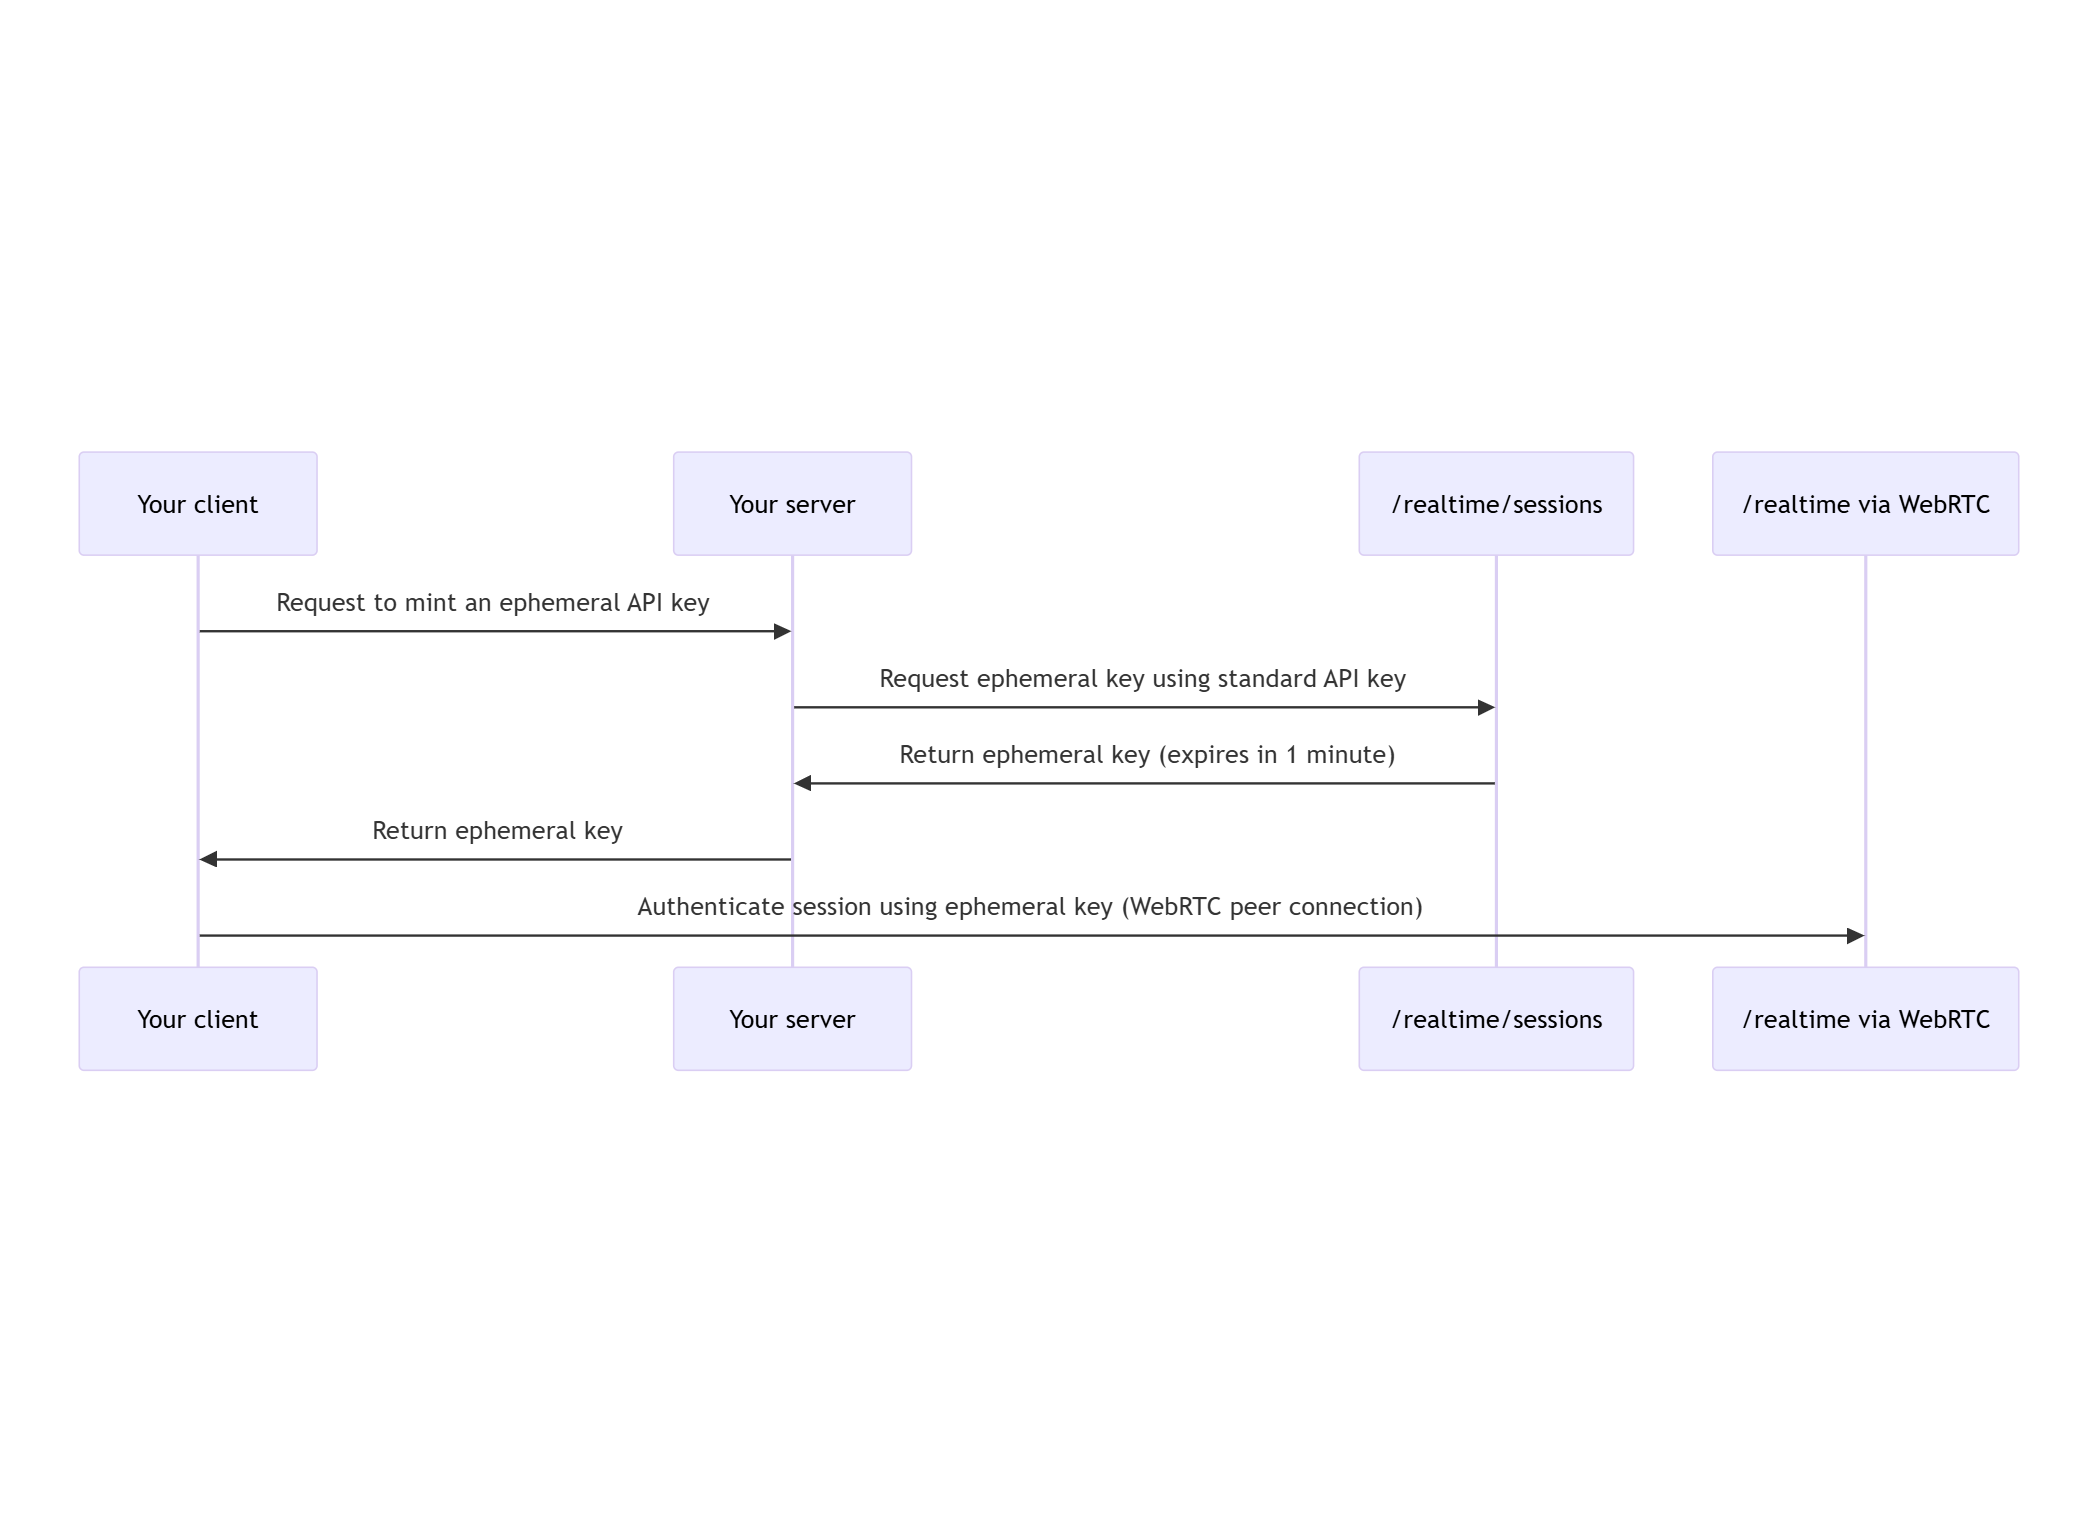

  
**Advantages**:  
- Lower latency for audio ("speech-in, speech-out").  
- No audio streaming through your own server = less load, more security.  
- Standard browser tech.  
  
|           | **Classic (WebSocket)** | **New (WebRTC)**           |  
|-----------|------------------------|----------------------------|  
| Audio Path| UI → Backend → Azure   | Browser ⇄ Azure (direct)   |  
| Security  | Your key on server     | Ephemeral key, safer       |  
| Latency   | Higher (relay)         | Lower (P2P, optimized)     |  
| Streaming | Manual/audio handling  | Browser-native             |  

# 🔐 Simulate Backend: Minting an Ephemeral Key for a Browser Session  

In [1]:
import requests  
from pprint import pprint
from dotenv import dotenv_values
import re
  
# Fill in your Azure info here
config = {
    **dotenv_values("./envs/.env")
}
AZURE_OPENAI_ENDPOINT = config["AZURE_OPENAI_ENDPOINT"]
# get resource name from endpoint
AZURE_RESOURCE_NAME = re.search(r"https://(.*?).openai.azure.com/", AZURE_OPENAI_ENDPOINT).group(1) # no https://, just the resource
API_KEY = config["AZURE_OPENAI_API_KEY"]  # NEVER put your real key here in a public notebook
DEPLOYMENT = config["AZURE_OPENAI_REALTIME_DEPLOYMENT"]
# DEPLOYMENT = "gpt-4o-mini-realtime-preview"  
VOICE = "verse"
#API_VERSION = "2024-10-01-preview"
API_VERSION = "2025-04-01-preview" # WebRTC API version 
  
def mint_ephemeral_key():  
    """  
    Performs the server-side step of minting a short-lived access key (ephemeral key),  
    which your frontend client will use for connecting to Azure via WebRTC.  
    """  
    SESSIONS_URL = (  
        f"https://{AZURE_RESOURCE_NAME}.openai.azure.com/openai/realtimeapi/sessions"  
        f"?api-version={API_VERSION}"  
    )  
    data = {  
        "model": DEPLOYMENT,  
        "voice": VOICE  
    }  
    headers = {  
        "api-key": API_KEY,  
        "Content-Type": "application/json"  
    }  
  
    response = requests.post(SESSIONS_URL, headers=headers, json=data)  
    if not response.ok:  
        print("Error:", response.status_code, response.text)  
        return None  
  
    result = response.json()  
    # Only send client_secret.value to the browser – never your real API key!  
    ephemeral_key = result['client_secret']['value']  
    session_id = result.get('id', '[unknown]')  
    print("Session ID:", session_id)  
    print("Ephemeral Key (valid for ~1 minute):", ephemeral_key)  
    # Optional: pprint(result) to see all session details  
    return ephemeral_key

In [2]:
# ❗️WARNING: For demo only. In production, you must only send ephemeral_key to your frontend!   
result = mint_ephemeral_key()

Session ID: sess_BTwZhRYlir9grG5PSFHhA
Ephemeral Key (valid for ~1 minute): ek_68191d55a3448190b2ae2bb245bf23b1


### IMPORTANT: Change the region in the gpt4o_webrtc_demo.html file
For east us2
```
const WEBRTC_URL = "https://eastus2.realtimeapi-preview.ai.azure.com/v1/realtimertc";
```

For sweden central
```
const WEBRTC_URL = "https://swedencentral.realtimeapi-preview.ai.azure.com/v1/realtimertc";
```

## Prepare the HTML Filling Utility  
  
Now that we have the HTML template (`gpt4o_webrtc_demo.html`) alongside our notebook, let's define a function to take our freshly minted ephemeral key, substitute it into the template,  and generate a ready-to-use browser demo page.

In [3]:
import webbrowser  
from pathlib import Path  
  
def fill_html_template(ephemeral_key,  
                      template_file="gpt4o_webrtc_demo.html",  
                      output_file="gpt4o_webrtc_filled.html"):  
    """  
    Reads a template HTML file with placeholder __EPHEMERAL_KEY__, substitutes your ephemeral key,  
    writes a new HTML file, and opens it in the browser.  
    """  
    template_path = Path(template_file)  
    output_path = Path(output_file)  
    html = template_path.read_text("utf-8")  
    html_filled = html.replace("__EPHEMERAL_KEY__", ephemeral_key)  
    output_path.write_text(html_filled, "utf-8")  
    print(f"Demo HTML prepared: {output_path.resolve()}")  
    webbrowser.open(f"file://{output_path.resolve()}")

## Mint and Use the Ephemeral Key for a Browser Session  
  
Let's now mint a new ephemeral key using the function provided earlier. Next, we’ll use our utility function to inject this key into the HTML template and immediately open the filled-in demo webpage in your browser for interaction!  

In [4]:
# Step 1: Mint the ephemeral key (ensure mint_ephemeral_key() is defined from previous steps)  
ephemeral_key = mint_ephemeral_key()  
  
# Step 2: If successful, produce and open the demo web page  
if ephemeral_key:  
    fill_html_template(ephemeral_key)  
else:  
    print("Could not obtain ephemeral key. Please check your Azure credentials/configuration.")

Session ID: sess_BTwZiauoZlOzDNDw0sw3U
Ephemeral Key (valid for ~1 minute): ek_68191d567cc48190ad3811bc17be90b2
Demo HTML prepared: C:\Users\yingdingwang\Documents\VCS\democollections\realtime-api-workshop\00-minimal-web-rtc-demo\gpt4o_webrtc_filled.html


## What Happens Now?  
  
- A new HTML file (`gpt4o_webrtc_filled.html`) is generated, containing your valid ephemeral key for this session.  
- This file is opened in your browser. You don't need to paste the key manually!  
- Use the demo interface in the browser as designed.  
  
If your key expires (usually within 1 minute), just re-run the cell above to mint a new key and refresh the page.  

## 🌐 Using the Realtime Demo Webpage  
  
When you open the HTML demo after minting your ephemeral key, you will interact with the Azure OpenAI GPT-4o voice model over a realtime WebRTC connection! As you use the site, you’ll see messages like:  
  
- `Data channel is open`  
- `Received event: {"type":"session.created", ...}`  
- Various other `Received event: {...}` logs describing the ongoing realtime conversation.  
  
These logs are actual events sent by the Azure service in response to your actions and audio. They provide insight into the underlying processing pipeline and session details.  
  
### 🔍 What Are These Events?  
  
Below is a summary of some key events you might see:  
  
- **`session.created`**: Your session is established! This includes details such as:  
    - `id`: The unique identifier for your session.  
    - `expires_at`: UNIX timestamp for session expiry (tokens are short-lived).  
    - `model`: Which voice model & deployment you’re using (e.g. `gpt-4o-mini-realtime-preview`).  
    - `instructions` and `voice`: Details about the assistant you’re interacting with.  
  
- **`input_audio_buffer.speech_started` / `speech_stopped`**: These indicate when your browser begins and ends sending voice input (i.e., speaking detected by the VAD).  
  
- **`conversation.item.created`**: A message (audio or text) has been successfully delivered—either by you (“user”) or the assistant (“assistant”).  
  
- **`response.created`, `response.audio_transcript.delta`**: The model is generating a reply. You’ll see a series of `delta` events as partial transcript/audio is streamed back; these are “chunks” of the AI’s reply. For example:  
    ```  
    Received event: {"type":"response.audio_transcript.delta", ..., "delta":"Hello"}  
    ...  
    Received event: {"type":"response.audio_transcript.delta", ..., "delta":"How can I assist you today?"}  
    ```  
    This shows the assistant is speaking back—transcribed in realtime for you to read.  
  
- **`response.audio_transcript.done`**: The full transcript of the model’s spoken/audio reply has been received.  
  
- **`rate_limits.updated`**, **`output_audio_buffer.started`/`stopped`**: Informational events about server-side throttling and audio streaming.  
  
### ℹ️ Where Do You See This?  
  
All these events are displayed in a “log” panel in the demo web page, so you can follow the conversation at the protocol level in realtime. They’re helpful for debugging, demonstrations, and understanding how Azure’s streaming AI voice model operates over WebRTC.  
  
> **Tip**: You can scroll in the event log to see the full details, including request IDs, message types, and more.  
  
---  
  
**Summary:**    
The browser log gives you deep visibility into:  
- Session setup and parameters  
- Timing and content of your voice input (and pauses)  
- Realtime, stream-by-stream AI model output—both audio and text  
- Status and summary for each conversational turn  
  
This makes the demo not only a practical assistant, but also a live tool for understanding Azure OpenAI’s realtime API!  